<a href="https://colab.research.google.com/github/MohamedKhalidmk/Generative_models/blob/main/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.models import Sequential as sequential
from tensorflow.keras.layers import Dense as dense
from tensorflow.keras import layers
from tabulate import tabulate

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() #load data

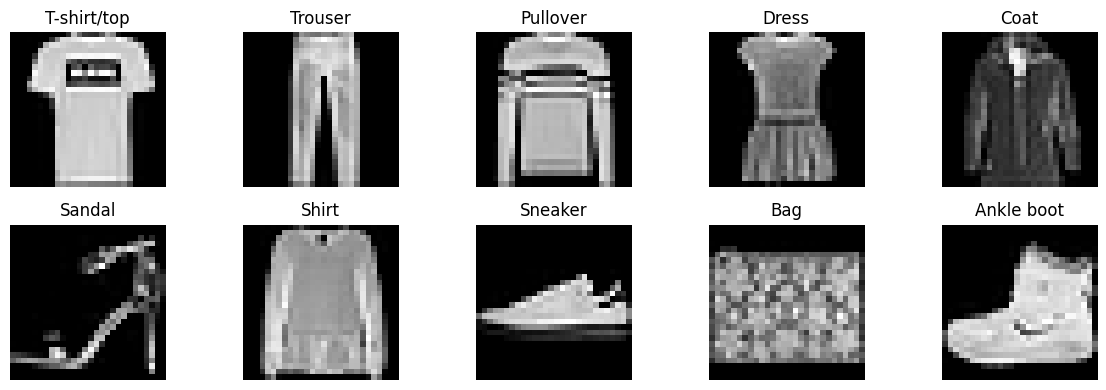

In [ ]:
class_names=[                                  #print a sample of each category
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]
samples=[]
for classidx,label in enumerate(class_names):
    image=x_train[y_train==classidx][0]
    samples.append((image,label))


# Plot the samples
plt.figure(figsize=(12, 4))
for i, (image, label) in enumerate(samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
x_train = x_train.reshape(x_train.shape[0],-1)/ 255.0   #scale,flatten
x_test = x_test.reshape(x_test.shape[0],-1)/ 255.0
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
def sample(probabilities, mode='bernoulli'):
    if mode == 'bernoulli':
        return tf.floor(probabilities + tf.random.uniform(tf.shape(probabilities), 0, 1))
    elif mode == 'gaussian':
        return probabilities + tf.random.normal(tf.shape(probabilities), mean=0.0, stddev=1)

class RBM:
    def __init__(self, n_visible, n_hidden, lr=0.01, epochs=10, mode='bernoulli'):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.lr = lr
        self.epochs = epochs
        self.mode = mode

        # Initialize weights and biases
        init_stddev = 4 * np.sqrt(6.0 / (self.n_hidden + self.n_visible))
        self.weights = tf.Variable(tf.random.normal([n_visible, n_hidden],
                                                    mean=0.0,
                                                    stddev=init_stddev),
                                                    dtype=tf.float32)

        self.vb = tf.Variable(tf.zeros([1, n_visible]), dtype=tf.float32)
        self.hb = tf.Variable(tf.zeros([1, n_hidden]), dtype=tf.float32)

        # Initialize reconstruction error attribute
        self.rec_error = tf.constant(0.0, dtype=tf.float32)

    def get_probabilities(self, x, mode='hidden'):
        # Ensure input is 2D
        if len(x.shape) == 1:
            x = tf.expand_dims(x, 0)  # (1, n_visible or n_hidden)

        if mode == 'hidden':
            if self.mode == 'bernoulli':
                return tf.nn.sigmoid(tf.matmul(x, self.weights) + self.hb)  # (batch, n_hidden)
            elif self.mode == 'gaussian':
                return tf.matmul(x, self.weights) + self.hb
        elif mode == 'visible':
            return tf.nn.sigmoid(tf.matmul(x, tf.transpose(self.weights)) + self.vb)  # (batch, n_visible)
        else:
            raise ValueError("mode must be 'hidden' or 'visible'")

    def CD(self, v, k=1):
        # Ensure input is 2D
        if len(v.shape) == 1:
            v = tf.expand_dims(v, 0)  # (1, n_visible)

        # Positive phase
        h_prob = self.get_probabilities(v, mode='hidden')
        h_state = sample(h_prob, mode=self.mode)

        pos_div = tf.matmul(tf.transpose(v), h_prob)  # Positive Divergence + h(v).v^T

        # negative phase
        fake_v_prob = self.get_probabilities(h_state, mode='visible')
        fake_v_state = fake_v_prob #can also sample fake v prob

        fake_h_prob = self.get_probabilities(fake_v_state, mode='hidden')
        fake_h_state = sample(fake_h_prob, mode=self.mode)

        for step in range(k - 1):
            fake_v_prob = self.get_probabilities(h_state, mode='visible')
            fake_v_state = fake_v_prob #can also sample fake v prob

            fake_h_prob = self.get_probabilities(fake_v_state, mode='hidden')
            fake_h_state = sample(fake_h_prob, mode=self.mode)

        neg_div = tf.matmul(tf.transpose(fake_v_state),fake_h_prob) #Negative Divergence - h(v').v'^T

        # Calculate weight and bias updates
        dw = pos_div - neg_div
        dvb = v - fake_v_state
        dhb = h_prob - fake_h_prob

        # # Similarity between reconstructed visible layer and input during training.
        self.rec_error = tf.reduce_mean(tf.square(v - fake_v_state))

        self.div=tf.reduce_mean(tf.abs(dw)) #how big the weight updates are on average

        return dw, dvb, dhb

    def update(self, v, k=1):
        # Ensure input is 2D
        if len(v.shape) == 1:
            v = tf.expand_dims(v, 0)

        batch_size = tf.cast(tf.shape(v)[0], tf.float32)

        dw, dvb, dhb = self.CD(v, k)

        # Scale updates by learning rate and batch size
        dw = (self.lr / batch_size) * dw
        dvb = (self.lr / batch_size) * (tf.reduce_sum(dvb, axis=0, keepdims=True))
        dhb = (self.lr / batch_size) * (tf.reduce_sum(dhb, axis=0, keepdims=True))

        # Apply updates
        train_ops = [
            self.weights.assign_add(dw),
            self.vb.assign_add(dvb),
            self.hb.assign_add(dhb),
        ]

        return train_ops

    def gibbs_sampling(self, v, steps=1):
        # Ensure input is 2D
        if len(v.shape) == 1:
            v = tf.expand_dims(v, 0)

        for _ in range(steps):
            h_prob = self.get_probabilities(v, mode='hidden')
            h_state = sample(h_prob, mode=self.mode)
            v_prob = self.get_probabilities(h_state, mode='visible')
            v = v_prob

        return v

    def get_feature_map(self):
        ft_map = {}
        for k in range(self.n_hidden):
            one_hot = tf.expand_dims(tf.one_hot(k, self.n_hidden), 0)  # (1, n_hidden)
            ft_map[k] = self.get_probabilities(one_hot, mode='visible')
        return ft_map


In [ ]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S") # setting up TensorBoard logging
log_dir = f"logs/rbm/{current_time}"
summary_writer = tf.summary.create_file_writer(log_dir)

In [ ]:
# Initialize RBM
rbm_model = RBM(n_visible=784, n_hidden=144, lr=0.01, epochs=10, mode='bernoulli')

In [ ]:
def show_digit(original, fake):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(original.numpy().reshape((28,28)), cmap=plt.cm.gray)
    ax1.set_title('Original digit')
    ax1.axis('off')  # remove axis from first plot

    ax2.imshow(fake.reshape((28,28)), cmap=plt.cm.gray)
    ax2.set_title('Sampled digit')
    ax2.axis('off')  # remove axis from second plot

    plt.show()


Epoch 1, Reconstruction Error (test): 0.2885


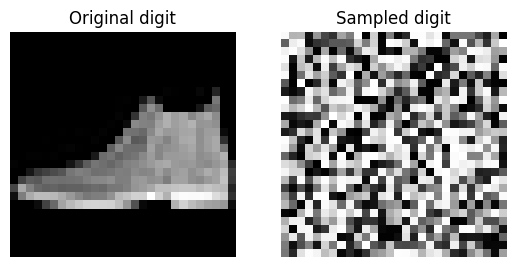

Epoch 2, Reconstruction Error (test): 0.0237


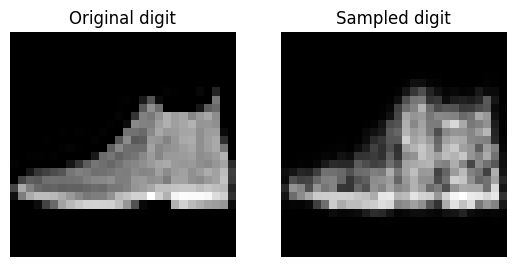

Epoch 3, Reconstruction Error (test): 0.0195


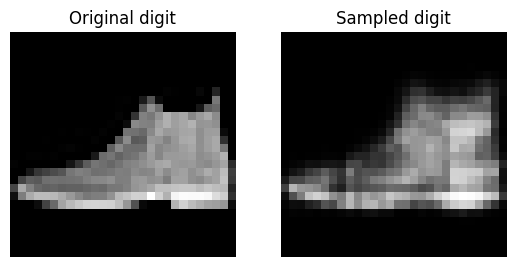

Epoch 4, Reconstruction Error (test): 0.0183


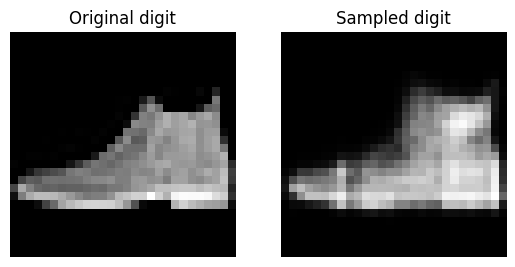

Epoch 5, Reconstruction Error (test): 0.0177


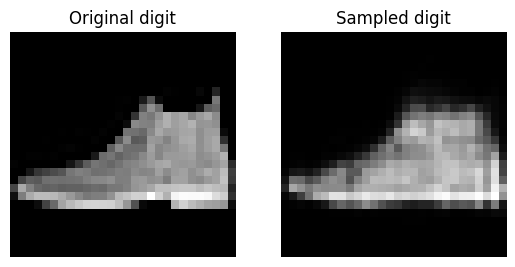

Epoch 6, Reconstruction Error (test): 0.0174


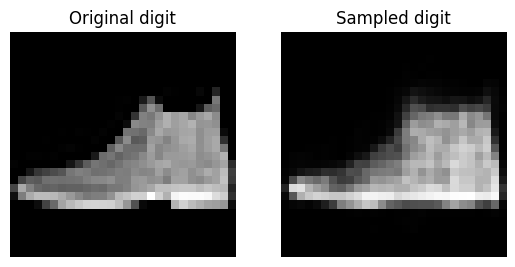

Epoch 7, Reconstruction Error (test): 0.0172


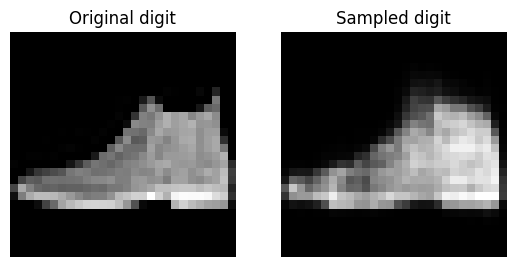

Epoch 8, Reconstruction Error (test): 0.0170


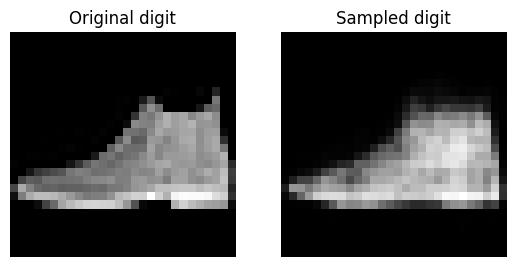

Epoch 9, Reconstruction Error (test): 0.0169


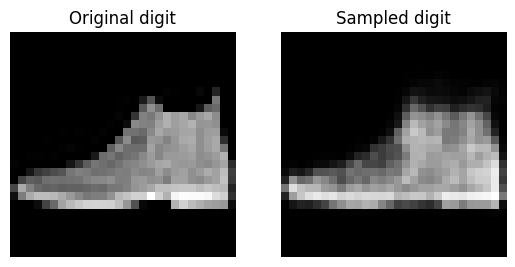

Epoch 10, Reconstruction Error (test): 0.0168


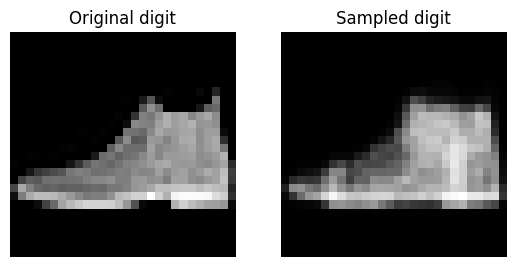

In [ ]:
for epoch in range(rbm_model.epochs):
    with tf.name_scope(f"Epoch_{epoch+1}"):
        # 1) Run Contrastive Divergence on the test set to update reconstruction error internally
        x_test = tf.cast(x_test, tf.float32)
        _ = rbm_model.CD(x_test, k=1)  # run CD to update rec_error
        rec_err_val = rbm_model.rec_error.numpy()
        print(f"Epoch {epoch+1}, Reconstruction Error (test): {rec_err_val:.4f}")

        # Write reconstruction error to TensorBoard
        with summary_writer.as_default():
            tf.summary.scalar("Reconstruction_Error", rec_err_val, step=epoch)

        # 2) Show a sample reconstruction from the test set using your show_digit function
        test_image = x_test[0]  # first test example, shape (784,)
        test_image_tensor = tf.expand_dims(test_image, axis=0)  # shape (1, 784)
        reconstructed = rbm_model.gibbs_sampling(test_image_tensor, steps=1).numpy()  # shape (1, 784)
        show_digit(test_image, reconstructed)  # show original and reconstructed digits side-by-side

        # 3) Train on all batches

        for step, batch_x in enumerate(x_train):
            with tf.name_scope("Train_Step"):
                batch_x = tf.cast(batch_x, tf.float32)
                _ = rbm_model.update(batch_x, k=1)

# After all epochs are done, close the summary writer
summary_writer.close()


In [ ]:
def generate_digit(rbm_model):
    # Start with a random hidden state
    h_sample = tf.cast(tf.random.uniform((1, rbm_model.n_hidden)) > 0.5, tf.float32)

    # Generate visible units from hidden state
    v_prob = tf.nn.sigmoid(tf.matmul(h_sample, tf.transpose(rbm_model.weights)) + rbm_model.vb)
    v_sample = v_prob

    return v_sample.numpy().reshape(28, 28)

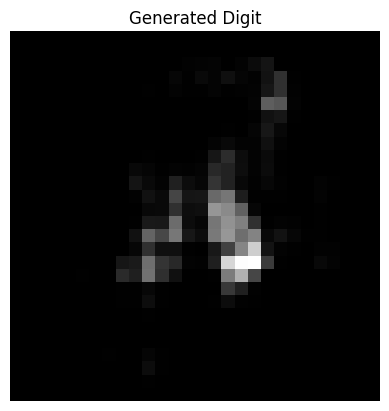

In [ ]:
new_digit = generate_digit(rbm_model)

# Show it
plt.imshow(new_digit, cmap=plt.cm.gray)
plt.axis('off')
plt.title("Generated Digit")
plt.show()

In [ ]:
def plot_features(ft_map):
  len_=int(np.sqrt(rbm_model.n_hidden))
  fig=plt.figure()
  features=[ft_map[i] for i in range(rbm_model.n_hidden)]
  for i in range(len_):
    for j in range(len_):
        ax=fig.add_subplot(len_,len_,i*len_+j+1)
        ax.matshow(features[i*len_+j].numpy().reshape((28,28)), cmap=plt.cm.gray)
        ax.axis('off')
  plt.show()


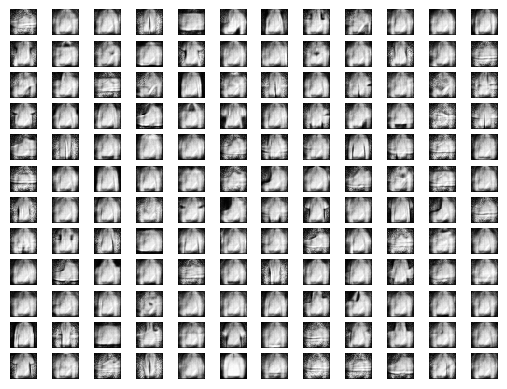

In [ ]:
ft_map=rbm_model.get_feature_map()
plot_features(ft_map)

In [ ]:
x_validation=x_train[:5000]
y_validation=y_train[:5000]
x_train=x_train[5000:]
y_train=y_train[5000:]
print(x_train.shape)
print(x_validation.shape)

(55000, 784)
(5000, 784)


In [ ]:
mlp_model=sequential([
    layers.Input(shape=(784,)),
    dense(128,activation='relu'),
    dense(64,activation='relu'),
    dense(10,activation='softmax')
])
mlp_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_mlp=mlp_model.fit(x_train,y_train,epochs=50,validation_data=(x_validation,y_validation))

Epoch 1/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5048 - accuracy: 0.8198 - val_loss: 0.4250 - val_accuracy: 0.8434
Epoch 2/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3770 - accuracy: 0.8625 - val_loss: 0.3472 - val_accuracy: 0.8778
Epoch 3/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3380 - accuracy: 0.8767 - val_loss: 0.3281 - val_accuracy: 0.8804
Epoch 4/50
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3134 - accuracy: 0.8850 - val_loss: 0.3267 - val_accuracy: 0.8844
Epoch 5/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2967 - accuracy: 0.8900 - val_loss: 0.3194 - val_accuracy: 0.8816
Epoch 6/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2819 - accuracy: 0.8958 - val_loss: 0.3147 - val_accuracy: 0.8880
Epoch 7/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2696 - accuracy: 0.8992 - val_loss: 0.3064 - val_accuracy:

In [ ]:
test_loss_mlp, test_acc_mlp = mlp_model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc_mlp}')
print(f'Test loss: {test_loss_mlp}')

313/313 [==============================] - 1s 3ms/step - loss: 0.6182 - accuracy: 0.8881
Test accuracy: 0.8881000280380249
Test loss: 0.6181714534759521


In [ ]:
x_train = tf.cast(x_train, tf.float32)             # Convert data to float32 tensors (required by RBM model)
x_validation = tf.cast(x_validation, tf.float32)

train_features = rbm_model.get_probabilities(x_train, mode='hidden').numpy()  #compute features for training,validation and testing
validation_features = rbm_model.get_probabilities(x_validation, mode='hidden').numpy()
test_features = rbm_model.get_probabilities(x_test, mode='hidden').numpy()

print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(55000, 144)
(5000, 144)
(10000, 144)


In [ ]:
mlp_features=sequential(
    [
      layers.Input(shape=(144,)),
      dense(128,activation='relu'),
      dense(64,activation='relu'),
      dense(10,activation='softmax')
    ]
)
mlp_features.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_features=mlp_features.fit(train_features,y_train,epochs=50,validation_data=(validation_features,y_validation))

Epoch 1/50
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5027 - accuracy: 0.8161 - val_loss: 0.4057 - val_accuracy: 0.8510
Epoch 2/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3957 - accuracy: 0.8519 - val_loss: 0.3678 - val_accuracy: 0.8612
Epoch 3/50
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3722 - accuracy: 0.8580 - val_loss: 0.3652 - val_accuracy: 0.8638
Epoch 4/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3575 - accuracy: 0.8632 - val_loss: 0.3689 - val_accuracy: 0.8602
Epoch 5/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3471 - accuracy: 0.8666 - val_loss: 0.3521 - val_accuracy: 0.8666
Epoch 6/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3361 - accuracy: 0.8716 - val_loss: 0.3517 - val_accuracy: 0.8646
Epoch 7/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3280 - accuracy: 0.8733 - val_loss: 0.3397 - val_accuracy:

In [ ]:
test_loss, test_acc = mlp_features.evaluate(test_features,y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

313/313 [==============================] - 1s 3ms/step - loss: 0.5704 - accuracy: 0.8488
Test accuracy: 0.848800003528595
Test loss: 0.5703790783882141


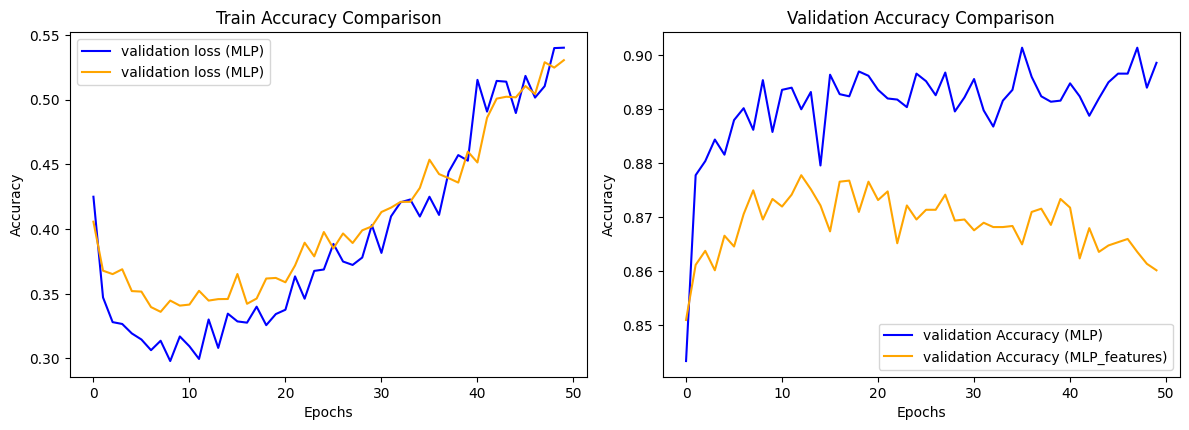

In [ ]:
    plt.figure(figsize=(12, 8))

    # Plot Validation loss Comparison between the two models
    plt.subplot(2, 2, 3)
    plt.plot(history_mlp.history['val_loss'], label='validation loss (MLP)', color='blue')
    plt.plot(history_features.history['val_loss'], label='validation loss (MLP)', color='orange')
    plt.title('Validation loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot validation accuracy comparison between the two models
    plt.subplot(2, 2, 4)
    plt.plot(history_mlp.history['val_accuracy'], label='validation Accuracy (MLP)', color='blue')
    plt.plot(history_features.history['val_accuracy'], label='validation Accuracy (MLP_features)', color='orange')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Create the results data
results_data = [
    ['MLP',
     round(history_mlp.history['loss'][-1], 4),
     round(history_mlp.history['accuracy'][-1], 4),
     round(history_mlp.history['val_loss'][-1], 4),
     round(history_mlp.history['val_accuracy'][-1], 4),
     round(test_acc_mlp,4),
     round(test_loss_mlp,4)
     ],

    ['MLP_features',
     round(history_features.history['loss'][-1], 4),
     round(history_features.history['accuracy'][-1], 4),
     round(history_features.history['val_loss'][-1], 4),
     round(history_features.history['val_accuracy'][-1], 4),
     round(test_acc,4),
     round(test_loss,4)
     ]
]

# Define headers
headers = ['Model', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy' , 'Test Accuracy' , 'Test Loss']

# Print the tabulated results
print(tabulate(results_data, headers=headers, tablefmt='fancy_grid'))


╒══════════════╤══════════════╤══════════════════╤═══════════════════╤═══════════════════════╤═════════════════╤═════════════╕
│ Model        │   Train Loss │   Train Accuracy │   Validation Loss │   Validation Accuracy │   Test Accuracy │   Test Loss │
╞══════════════╪══════════════╪══════════════════╪═══════════════════╪═══════════════════════╪═════════════════╪═════════════╡
│ MLP          │       0.0942 │           0.9631 │            0.5401 │                0.8986 │          0.8881 │      0.6182 │
├──────────────┼──────────────┼──────────────────┼───────────────────┼───────────────────────┼─────────────────┼─────────────┤
│ MLP_features │       0.157  │           0.9378 │            0.5305 │                0.8602 │          0.8488 │      0.5704 │
╘══════════════╧══════════════╧══════════════════╧═══════════════════╧═══════════════════════╧═════════════════╧═════════════╛
